## Importing libraries

In [2]:
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.preprocessing import image_dataset_from_directory
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
import os

2025-11-14 18:18:41.903509: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1763144322.099115      48 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1763144322.166201      48 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

## Dataset

In [3]:
DATASET_DIR = Path('/kaggle/input/waste-classification-images/dataset')
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
RANDOM_SEED = 123
NUM_EPOCHS = 15 

## Splitting

In [9]:
train_ds = image_dataset_from_directory(
    DATASET_DIR,
    validation_split=0.2,
    subset="training",
    seed=RANDOM_SEED,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)

print("Loading validation dataset...")
val_ds = image_dataset_from_directory(
    DATASET_DIR,
    validation_split=0.2,
    subset="validation",
    seed=RANDOM_SEED,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)

Found 2622 files belonging to 4 classes.
Using 2098 files for training.
Loading validation dataset...
Found 2622 files belonging to 4 classes.
Using 524 files for validation.


In [10]:
class_names = train_ds.class_names
NUM_CLASSES = len(class_names)
print(f"Class names: {class_names}")
print(f"Number of classes: {NUM_CLASSES}")

# GPU optimization
AUTOTUNE = tf.data.AUTOTUNE


def apply_mobilenet_preprocessing(image, label):
    image = tf.keras.applications.mobilenet_v2.preprocess_input(image)
    return image, label

train_ds = train_ds.map(apply_mobilenet_preprocessing).cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.map(apply_mobilenet_preprocessing).prefetch(buffer_size=AUTOTUNE)

Class names: ['1-Plastic', '2-Paper', '3-Metal', '4-Food Organics']
Number of classes: 4


In [11]:
data_augmentation = tf.keras.Sequential([
  layers.RandomFlip("horizontal"),
  layers.RandomRotation(0.1),
  layers.RandomZoom(0.1),
  layers.RandomContrast(0.1)
])

## model defining

In [12]:
base_model = tf.keras.applications.MobileNetV2(
    input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3),
    include_top=False,
    weights='imagenet'
)

base_model.trainable = False

model = models.Sequential([
    data_augmentation,
    base_model,                             
    layers.GlobalAveragePooling2D(),        
    layers.Dropout(0.2),                    
    layers.Dense(NUM_CLASSES, activation='softmax') 
])

In [13]:
model.compile(
    optimizer=optimizers.Adam(learning_rate=0.0001),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_1 (Sequential)       │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ ?                      │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,257,984 (8.61 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 2,257,984 (8.61 MB)

In [14]:
print("\nStarting model training...")
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=NUM_EPOCHS
)


Starting model training...
Epoch 1/15


I0000 00:00:1763144514.726125     122 cuda_dnn.cc:529] Loaded cuDNN version 90300


66/66 ━━━━━━━━━━━━━━━━━━━━ 20s 100ms/step - accuracy: 0.3591 - loss: 1.4521 - val_accuracy: 0.4866 - val_loss: 1.1429
Epoch 2/15
66/66 ━━━━━━━━━━━━━━━━━━━━ 4s 62ms/step - accuracy: 0.4993 - loss: 1.1516 - val_accuracy: 0.5744 - val_loss: 0.9870
Epoch 3/15
66/66 ━━━━━━━━━━━━━━━━━━━━ 4s 63ms/step - accuracy: 0.5913 - loss: 0.9705 - val_accuracy: 0.6298 - val_loss: 0.8777
Epoch 4/15
66/66 ━━━━━━━━━━━━━━━━━━━━ 4s 64ms/step - accuracy: 0.6305 - loss: 0.8929 - val_accuracy: 0.6737 - val_loss: 0.8129
Epoch 5/15
66/66 ━━━━━━━━━━━━━━━━━━━━ 4s 64ms/step - accuracy: 0.6804 - loss: 0.7799 - val_accuracy: 0.7023 - val_loss: 0.7680
Epoch 6/15
66/66 ━━━━━━━━━━━━━━━━━━━━ 4s 64ms/step - accuracy: 0.7086 - loss: 0.7323 - val_accuracy: 0.7195 - val_loss: 0.7324
Epoch 7/15
66/66 ━━━━━━━━━━━━━━━━━━━━ 4s 65ms/step - accuracy: 0.7390 - loss: 0.6728 - val_accuracy: 0.7233 - val_loss: 0.7112
Epoch 8/15
66/66 ━━━━━━━━━━━━━━━━━━━━ 4s 65ms/step - accuracy: 0.7556 - loss: 0.6382 - val_accuracy: 0.7500 - val_loss: 

In [17]:
model_save_path = '/kaggle/working/mobilenet_waste_classifier.keras'

model.save(model_save_path)

print(f"Model saved to {model_save_path}")

Model saved to /kaggle/working/mobilenet_waste_classifier.keras


## validation

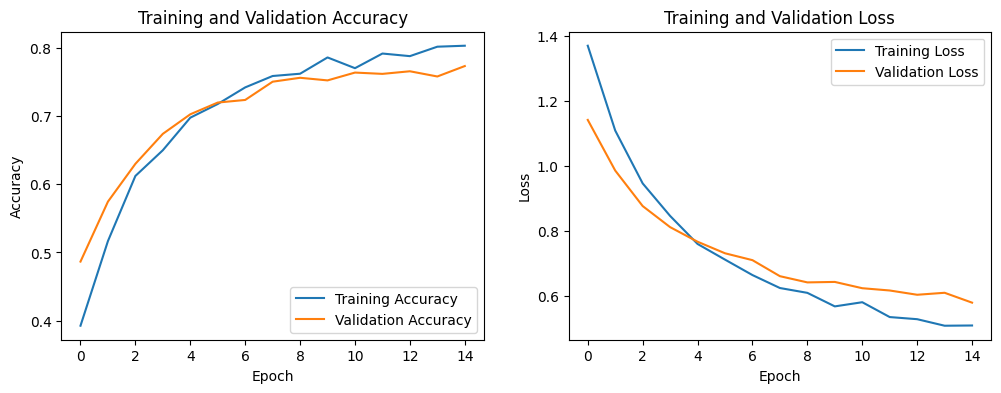

In [18]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [19]:

def predict_custom_image(model_path, image_path, class_names, img_size=(224, 224)):
    """Predicts the class of a single custom image using the MobileNetV2-based model."""
    try:
        model = tf.keras.models.load_model(model_path)
    except Exception as e:
        print(f"Error loading model: {e}")
        return None, None

    try:
        img = tf.keras.utils.load_img(image_path, target_size=img_size)
        img_array = tf.keras.utils.img_to_array(img)
        img_array = np.expand_dims(img_array, axis=0) 
        
        processed_img_array = tf.keras.applications.mobilenet_v2.preprocess_input(img_array)
            
    except Exception as e:
        print(f"Error processing image: {e}")
        return None, None

    predictions = model.predict(processed_img_array)
    predicted_index = np.argmax(predictions[0])
    predicted_class = class_names[predicted_index]
    confidence = predictions[0][predicted_index]

    return predicted_class, confidence

In [41]:
CUSTOM_IMAGE_PATH = '/kaggle/input/paperrr/paper.jpg' 

predicted_class, confidence = predict_custom_image(
    model_save_path, 
    CUSTOM_IMAGE_PATH, 
    class_names, 
    IMG_SIZE
)
if predicted_class:
    print(f"Image Path: {CUSTOM_IMAGE_PATH}")
    print(f"Predicted Class: {predicted_class[2:]}")
    print(f"Confidence: {confidence:.2%}") 

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Image Path: /kaggle/input/paperrr/paper.jpg
Predicted Class: Paper
Confidence: 93.24%


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


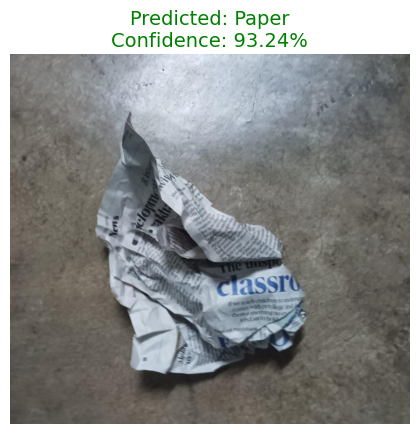

Image Path: /kaggle/input/paperrr/paper.jpg
Predicted Class: Paper
Confidence: 93.24%


In [48]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np

CUSTOM_IMAGE_PATH = '/kaggle/input/paperrr/paper.jpg' 

predicted_class, confidence = predict_custom_image(
    model_save_path, 
    CUSTOM_IMAGE_PATH, 
    class_names, 
    IMG_SIZE
)

if predicted_class:

    img = mpimg.imread(CUSTOM_IMAGE_PATH)
    plt.imshow(img)
    plt.axis('off')
    
    display_class = predicted_class[2:]

    plt.title(
        f"Predicted: {display_class}\n"
        f"Confidence: {confidence:.2%}",
        fontsize=14,
        color='green' if confidence > 0.7 else 'red'
    )
    plt.show()

    print(f"Image Path: {CUSTOM_IMAGE_PATH}")
    print(f"Predicted Class: {display_class}")
    print(f"Confidence: {confidence:.2%}")